# Neural Networks, Gradients, and Deep Learning


I explore multimodal learning by using a Convolutional Neural Network (CNN) in order to predict housing prices based on the basic information on the house (such as the number of bedrooms, bathroom, square footage,zipcode, etc) and images of the house. The architecture includes ReLU activation functions in all layers (including output), SGD optimizer, learning rate of 0.01, mean square error loss function, two hidden layers with 1024 neurons each, and one hidden output layer with an adequate number of neurons in the output layer for the regression problem.

In [1]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
import numpy as np
import pandas as pd
from IPython.display import Image
import torch
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from typing import Dict, Any
import os

%matplotlib inline

#define a function to keep track of loss as the networks are trained

def live_plot(loss, train_acc, valid_acc=None, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(loss, label='Training Loss', color='red')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Mean Square Error Loss')
    ax2 = ax1.twinx()
    ax2.plot(train_acc, label='Training MSE', color='green')
    if valid_acc is not None:
        ax2.plot(valid_acc, label='Validation MSE', color='blue')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('Epoch')
    plt.title(title)
    plt.show()

In [4]:
HouseData = pd.read_csv('HousesDatasetClean/HousesInfo.csv')
HouseData.drop(columns='zipcode', inplace=True)
HouseData.describe()

,bedrooms,bathrooms,area,price
count,535.000000,535.000000,535.000000,5.350000e+02
mean,3.377570,2.664953,2364.904673,5.893628e+05
std,1.160952,0.995077,1224.556982,5.090261e+05
min,1.000000,1.000000,701.000000,2.200000e+04
25%,3.000000,2.000000,1440.000000,2.492000e+05
50%,3.000000,2.500000,2078.000000,5.290000e+05
75%,4.000000,3.000000,3067.500000,7.285000e+05
max,10.000000,7.000000,9583.000000,5.858000e+06


In [6]:
# Data iterators
class StructuredDataset(Dataset):
    def __init__(self, x, y):
        super(StructuredDataset, self).__init__()
        assert x.shape[0] == y.shape[0]
        if torch.cuda.is_available():
            device = 'cuda'
        else:
            device = 'cpu'
        self.x_data = torch.as_tensor(x, device=device, dtype=torch.float)
        self.y_data = torch.as_tensor(y, device=device, dtype=torch.float)


    def __len__(self):
        return self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]


# Load data into 'flattened' NumPy arrays [5 pts]
train, test = train_test_split(HouseData, 
                               test_size = 0.3,
                               random_state = 20201207)


# Normalize the data
normalizer = StandardScaler()
train = normalizer.fit_transform(train)
test = normalizer.transform(test)

# Define the dataset
traindata = StructuredDataset(train[:, :-1], train[:, -1])

# Create iterator. Pass this to the enumerate function.
batch_size = 32
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True)

In [7]:
# Define the architecture
class NonLinearModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size=1024, num_classes=1):
        super().__init__()
        
        #NN architecture
        self.dense1=torch.nn.Linear(in_features=num_features, out_features=hidden_size)
        self.activation1=torch.nn.ReLU()
        self.dense2=torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.activation2=torch.nn.ReLU()
        self.dense3=torch.nn.Linear(in_features=hidden_size, out_features=num_classes)
        self.activation3=torch.nn.ReLU()
        
    def forward(self, X):
        X=self.dense1(X)
        X=self.activation1(X)
        X=self.dense2(X)
        X=self.activation2(X)
        X=self.dense3(X)
        X=self.activation3(X)
        return X

In [12]:
#Initiate the model
num_features=3
model=NonLinearModel(num_features, 1024, 1)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

NonLinearModel(
  (dense1): Linear(in_features=3, out_features=1024, bias=True)
  (activation1): ReLU()
  (dense2): Linear(in_features=1024, out_features=1024, bias=True)
  (activation2): ReLU()
  (dense3): Linear(in_features=1024, out_features=1, bias=True)
  (activation3): ReLU()
)

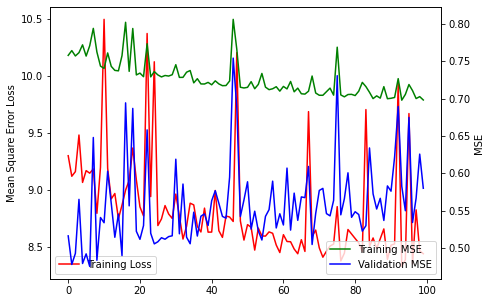

In [20]:
# Train the network
max_iter=100 #train for a maximum number of iterations
optimizer=torch.optim.SGD(model.parameters(),lr=1e-2)
criterion=torch.nn.MSELoss()

loss_list=[] #some containers to hold the loss, mse, and validation error for each epoch
mse_list=[]
valid_list=[]

#now start the iterations
for i in range(max_iter):
    epoch_loss=0 #initialize the loss for each epoch
    for index, (data, label) in enumerate(trainloader):
        optimizer.zero_grad()#initialize the optimizer
        y_pred=model(data.cpu())
        loss=criterion(input=y_pred.cpu(), target=label.reshape(-1,1).cpu())
        loss.backward() #backward propagation of the gradient
        optimizer.step() #take the next step
        epoch_loss+=loss.item()
        print(f"Batch %i loss: %0.3f" % (index+1, loss.item()), end='\r')
        
    with torch.no_grad():
        loss_list.append(epoch_loss) # store the loss for each epoch
        y_pred=model.forward(torch.Tensor(train[:,:-1]).cpu())
        mse_list.append(mean_squared_error(y_true=train[:,-1],y_pred=y_pred.cpu()))
        y_pred_val=model.forward(torch.Tensor(test[:,:-1]).cpu())
        valid_list.append(mean_squared_error(y_true=test[:,-1],y_pred=y_pred_val.cpu()))
        live_plot(np.array(loss_list),np.array(mse_list),valid_list)
    

Observation: Since we are seeing some patterns over the training set (ie there is a slowly decaying MSE in the training set and decaying training loss) there is indeed some learning going on, but we are not really seeing these patterns translated to the test set.

Now let's explore the effects of different aspects of the architecture in the network. Lets try:

1)Try using just one hidden layer and the two you used above.

2)Changing the number of neurons in the hidden layer. Try 512, 1024 and 2048 (keep the same number in both layers when using 2).

3)Changing the learning rate. Reduce it to $10^{-4}$ and increase it to $10^{-1}$.

In [40]:

#lets set the parameters we want to iterate over and create a parameter grid
#out of them.
learning_rate=[0.0001, 0.1]
hidden_size=[512, 1024, 2048]
from itertools import product
param_grid=product(learning_rate, hidden_size)

Double-layer net. LR: 0.0001, HS: 512. MSE test set=0.515


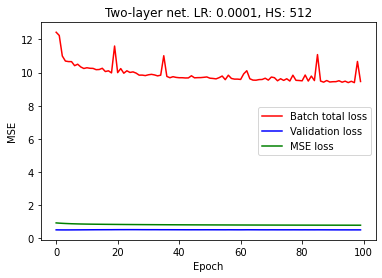

Double-layer net. LR: 0.0001, HS: 1024. MSE test set=0.508


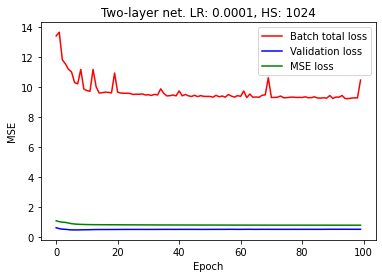

Double-layer net. LR: 0.0001, HS: 2048. MSE test set=0.502


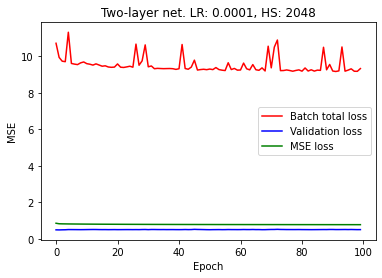

Double-layer net. LR: 0.1000, HS: 512. MSE test set=0.519


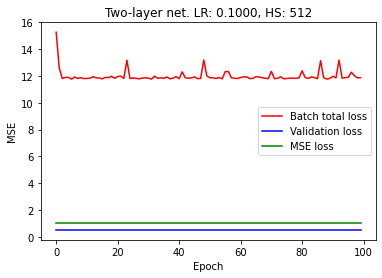

Double-layer net. LR: 0.1000, HS: 1024. MSE test set=0.519


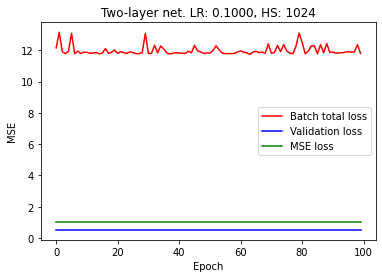

Double-layer net. LR: 0.1000, HS: 2048. MSE test set=0.519


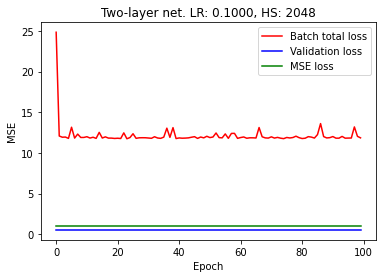

In [38]:
#now start by iterating over a network with two layers
for (lr, hl) in param_grid:
    model=NonLinearModel(num_features, hl, 1)
    model.to(device)
    optimizer=torch.optim.SGD(model.parameters(), lr=lr)
    
    
    loss_list = []
    mse_list = []
    valid_list = []
    
    for i in range(max_iter):
        epoch_loss = 0
        for index, (data, label) in enumerate(trainloader):
            optimizer.zero_grad()
            y_pred = model(data.cpu())
            loss = criterion(input=y_pred.cpu(), target=label.reshape(-1, 1).cpu())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"Batch %i loss: %0.3f" % (index+1, loss.item()), end='\r')

        with torch.no_grad():
            loss_list.append(epoch_loss)
            y_pred = model.forward(torch.Tensor(train[:, :-1]).cpu())
            mse_list.append(mean_squared_error(y_true=train[:, -1], 
                                                y_pred=y_pred.cpu()))
            y_pred_val = model.forward(torch.Tensor(test[:, :-1]).cpu())
            valid_list.append(mean_squared_error(y_true=test[:, -1], 
                                              y_pred=y_pred_val.cpu()))

    print('Double-layer net. LR: %.4f, HS: %i. MSE test set=%.3f' % (lr, hl, valid_list[-1]))
    plt.plot(loss_list, color="red", label = "Batch total loss")
    plt.plot(valid_list, color="blue", label = "Validation loss")
    plt.plot(mse_list, color="green", label = "MSE loss")
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Two-layer net. LR: %.4f, HS: %i' % (lr, hl))
    plt.legend()
    plt.savefig('Model_lr'+str(lr)+'_hl'+str(hl)+'_twolayers.pdf')
    plt.show()

Double-layer net. LR: 0.0001, HS: 512. MSE test set=0.522


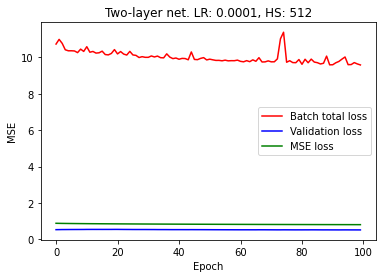

Double-layer net. LR: 0.0001, HS: 1024. MSE test set=0.519


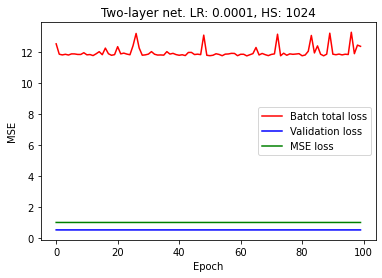

Double-layer net. LR: 0.0001, HS: 2048. MSE test set=0.519


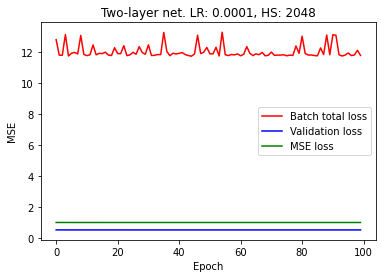

Double-layer net. LR: 0.1000, HS: 512. MSE test set=0.519


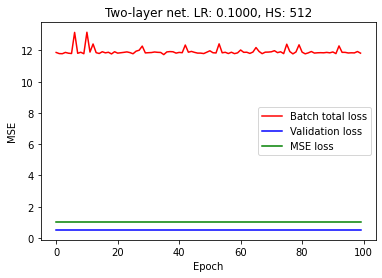

Double-layer net. LR: 0.1000, HS: 1024. MSE test set=0.519


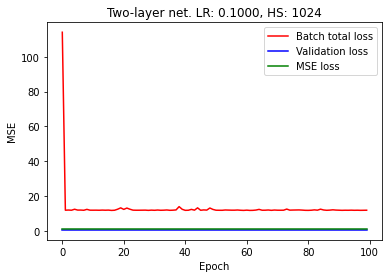

Double-layer net. LR: 0.1000, HS: 2048. MSE test set=0.519


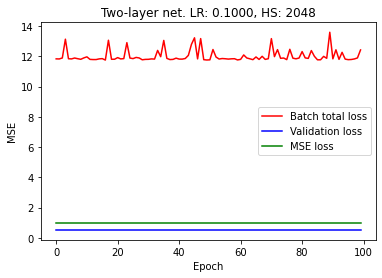

In [41]:
# now define a new architecture for a NN with only the one hidden layer
class NonLinearModel(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size = 1024, num_classes=1):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=hidden_size)
        self.activation1 = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(in_features=hidden_size, out_features=num_classes)
        self.activation2 = torch.nn.ReLU()

    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X
    
#just copy and paste the code from the iterations in the cell above to repeat the whole process
for (lr, hl) in param_grid:
    model=NonLinearModel(num_features, hl, 1)
    model.to(device)
    optimizer=torch.optim.SGD(model.parameters(), lr=lr)
    
    
    loss_list = []
    mse_list = []
    valid_list = []
    
    for i in range(max_iter):
        epoch_loss = 0
        for index, (data, label) in enumerate(trainloader):
            optimizer.zero_grad()
            y_pred = model(data.cpu())
            loss = criterion(input=y_pred.cpu(), target=label.reshape(-1, 1).cpu())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"Batch %i loss: %0.3f" % (index+1, loss.item()), end='\r')

        with torch.no_grad():
            loss_list.append(epoch_loss)
            y_pred = model.forward(torch.Tensor(train[:, :-1]).cpu())
            mse_list.append(mean_squared_error(y_true=train[:, -1], 
                                                y_pred=y_pred.cpu()))
            y_pred_val = model.forward(torch.Tensor(test[:, :-1]).cpu())
            valid_list.append(mean_squared_error(y_true=test[:, -1], 
                                              y_pred=y_pred_val.cpu()))

    print('Double-layer net. LR: %.4f, HS: %i. MSE test set=%.3f' % (lr, hl, valid_list[-1]))
    plt.plot(loss_list, color="red", label = "Batch total loss")
    plt.plot(valid_list, color="blue", label = "Validation loss")
    plt.plot(mse_list, color="green", label = "MSE loss")
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Two-layer net. LR: %.4f, HS: %i' % (lr, hl))
    plt.legend()
    plt.savefig('Model_lr'+str(lr)+'_hl'+str(hl)+'_twolayers.pdf')
    plt.show()

High learning rate causes the model to never learn anything therefore lower learning rate is bad; smaller number of neurons in the hidden layer leads to better prediction; larger number of hidden layers leads to better models.

Now we will train a custom convolutional neural network that takes the images, creates a train / test split, and calculates the price of the house given the images. 

In [44]:
# How we will transform the images.
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(255),   # Scale images from 0-255 to 0-1
                                            torchvision.transforms.ToTensor()])   # Transform everything to a pytorch tensor

# Add path to images.
ImagePath = 'HousesDatasetClean/1' # This works on Windows. In OSX or Linux (Colab), use 'HousesDatasetClean/1'
HouseData['path'] = [os.path.join(ImagePath, str(i) + '.jpg') for i in HouseData.index.values]   # Create the image path
HouseData.head()  # See what comes out

# Read the data from the folder
class RegressionImageFolder(torchvision.datasets.ImageFolder):
    def __init__(
        self, root: str, image_scores: Dict[str, float], **kwargs: Any
    ) -> None:
        super().__init__(root, **kwargs)
        paths, _ = zip(*self.imgs)
        self.targets = [image_scores[path] for path in paths]
        self.samples = self.imgs = list(zip(paths, self.targets))

# In Torch I can't see the labels, so I'll normalize the whole thing.
HouseData['price'] = (HouseData['price'] - np.mean(HouseData['price'])) / np.std(HouseData['price'])

# Create the data loader
img_dataset = RegressionImageFolder('HousesDatasetClean', transform=transform,
                                   image_scores = dict(zip(HouseData['path'], HouseData['price'])))

# Create the dataloaders
dataset_train, dataset_valid = torch.utils.data.random_split(img_dataset, (375, 160))




batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=dataset_valid, shuffle=False, batch_size=batch_size)

In [45]:
class ConvNet(torch.nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            torch.nn.Conv2d(64, 4, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.linear_layers=torch.nn.Sequential(
        torch.nn.Linear(23940, 1024),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(1024, 1),
        torch.nn.ReLU(inplace=True))

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x=self.linear_layers(x)

        # Return model
        return x

In [46]:
# Your code here
model=ConvNet()

#define the optimizer - you want a smaller learning rate for a more complex data set
optimizer=torch.optim.SGD(model.parameters(),lr=0.00001)
#define the loss function
criterion=torch.nn.MSELoss()

#check if GPU is available
if torch.cuda.is_available():
    model=model.cuda()
    criterion=criterion.cuda()
    
print(model)

ConvNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=23940, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1, bias=True)
    (3): ReLU(inplace=True)
  )
)


In [48]:
# Train!

max_iter=10
valid_list=[]
train_list=[]

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
#         if torch.cuda.is_available():
#             data = data.to(device)
#             label = label.to(device)
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label.reshape(-1, 1).float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch %i loss: %0.3f" % (index+1, loss.item()), end='\r')

    with torch.no_grad():
        y_pred_val = []
        y_real = []
        for data in val_loader:
            images, labels = data
            images = images.cpu()
            labels = labels.cpu()
            outputs = model(images)
            y_pred_val.append(outputs.cpu().numpy())
            y_real.append(labels.cpu().numpy())
        y_real = np.concatenate(y_real).ravel()
        y_pred_val = np.concatenate(y_pred_val).ravel()
        valid_list.append(mean_squared_error(y_true=y_real, y_pred=y_pred_val))
        train_list.append(epoch_loss)

KeyboardInterrupt: 

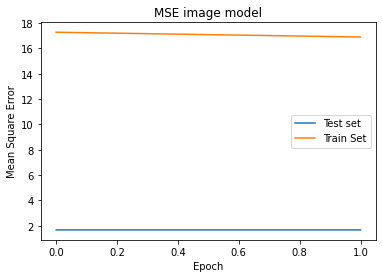

In [49]:
#plot the losses
plt.plot(valid_list, label='Test set')
plt.plot(train_list, label='Train Set')

plt.title('MSE image model')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()